A notebook to use Siphon to fetch data from Unidata THREDDS to look at trends over the midwest region for a week to the next 24 hours. This demo includes some sample, technical visualizations.

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import netCDF4
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import numpy as np
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
from datetime import datetime, timedelta
from netCDF4 import num2date
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

%matplotlib inline


In [3]:
best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p5deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p5deg/Best')
best_gfs.datasets
best_ds = list(best_gfs.datasets.values())[0]
best_ds.access_urls
ncss = NCSS(best_ds.access_urls['NetcdfSubset'])

In [64]:
def plot_pcolor_mslp(ncss, bbox, forecast_hour=0, tk=.5, var='Temperature_surface',
                    vmin=None, vmax=None, mult=1.0, add = 0.0, vlevel = None,
                    unit = None):
    north = bbox[3]
    south = bbox[2]
    west = bbox[1]
    east = bbox[0]
    
    #MSLP first
    query = ncss.query()
    query.lonlat_box(north=north, south=south, 
                     east=east, west=west).time(datetime.utcnow() + timedelta(hours=forecast_hour))
    query.accept('netcdf4')
    query.variables('MSLP_Eta_model_reduction_msl')
    data = ncss.get_data(query)
    mslp_var = data.variables['MSLP_Eta_model_reduction_msl']
    
    #now our pcolor
    query = ncss.query()
    if vlevel is None:
        query.lonlat_box(north=north, south=south, 
                         east=east, west=west).time(datetime.utcnow() + timedelta(hours=forecast_hour))
    else:
        query.lonlat_box(north=north, south=south, 
                         east=east, west=west).vertical_level(vlevel).time(datetime.utcnow() + timedelta(hours=forecast_hour))

    query.accept('netcdf4')
    query.variables(var)
    data = ncss.get_data(query)
    print(data.variables.keys())
    sel_var = data.variables[var]
    
    if vlevel is not None:
        level_name = sel_var.coordinates.split()[2]
        level_var = data.variables[level_name]
        print(level_var[:])
        level_text = " at {0}{1}".format(level_var[0], level_var.units)
    else:
        level_text = ""
    
    # Time variables can be renamed in GRIB collections. Best to just pull it out of the
    # coordinates attribute on temperature
    time_name = sel_var.coordinates.split()[1]
    time_var = data.variables[time_name]
    lat_var = data.variables['lat']
    lon_var = data.variables['lon']

    sel_vals = sel_var[:].squeeze()*mult + add
    lat_vals = lat_var[:].squeeze()
    lon_vals = lon_var[:].squeeze()
    mslp_vals = mslp_var[:].squeeze() / 100.0 

    # Convert the number of hours since the reference time to an actual date
    time_val = num2date(time_var[:].squeeze(), time_var.units)


    # Combine 1D latitude and longitudes into a 2D grid of locations
    lon_2d, lat_2d = np.meshgrid(lon_vals, lat_vals)

    # Create a new figure
    fig = plt.figure(figsize=(15, 12))

    # Add the map and set the extent
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_xticks(np.arange(west, east, tk), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(south, north, tk), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    ax.set_extent(bbox)

    # Add state boundaries to plot
    coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                                facecolor='none', name='coastline')
    _ = ax.add_feature(coast, edgecolor='black')


    # Contour temperature at each lat/long
    if vmin is None:
        vmin = sel_vals.min()
    
    if vmax is None:
        vmax = sel_vals.max()
    
    cf = ax.pcolormesh(lon_2d, lat_2d, sel_vals, transform=ccrs.PlateCarree(), zorder=0,
                     cmap='coolwarm', vmin=vmin, vmax=vmax)

    cn = ax.contour(lon_2d, lat_2d, mslp_vals, np.arange(950, 1040, 2), colors='black')

    plt.clabel(cn, inline=1, fontsize=15, fmt='%1.0f')


    # Plot a colorbar to show temperature and reduce the size of it
    plt.colorbar(cf, ax=ax, fraction=0.032)
    
    if unit is None:
        unit = sel_var.units

    # Make a title with the time value
    ax.set_title(var + \
                  level_text + u' forecast '+ unit +'  for {0:%d %B %Y %H:%MZ}'.format(time_val),
                 fontsize=20)
    
    return ax

odict_keys(['Temperature_height_above_ground', 'reftime1', 'time1', 'height_above_ground4', 'lat', 'lon'])
[ 2.]


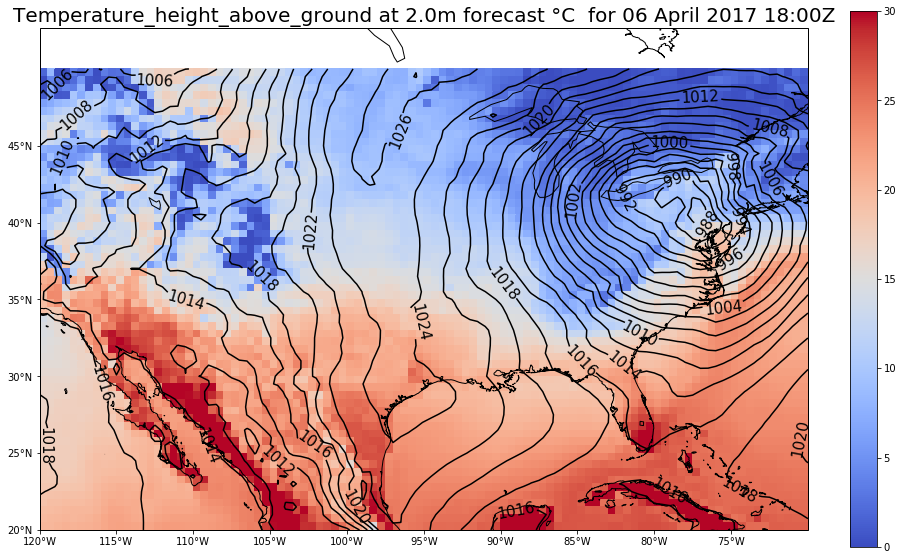

In [90]:
bbox = [-70, -120, 20,50]
my_ax = plot_pcolor_mslp(ncss, bbox, var='Temperature_height_above_ground',
                        vmin=0.0, vmax=30, tk=5, forecast_hour=3, add = -273.15,
                        vlevel=0, unit = u'\u00b0C')

#my_ax.add_feature(cfeature.NaturalEarthFeature)
my_ax.add_feature(cfeature.LAKES, edgecolor='k', facecolor='none')
plt.savefig('/Users/scollis/foo.png')

odict_keys(['Precipitation_rate_surface_Mixed_intervals_Average', 'reftime2', 'time2', 'lat', 'lon'])


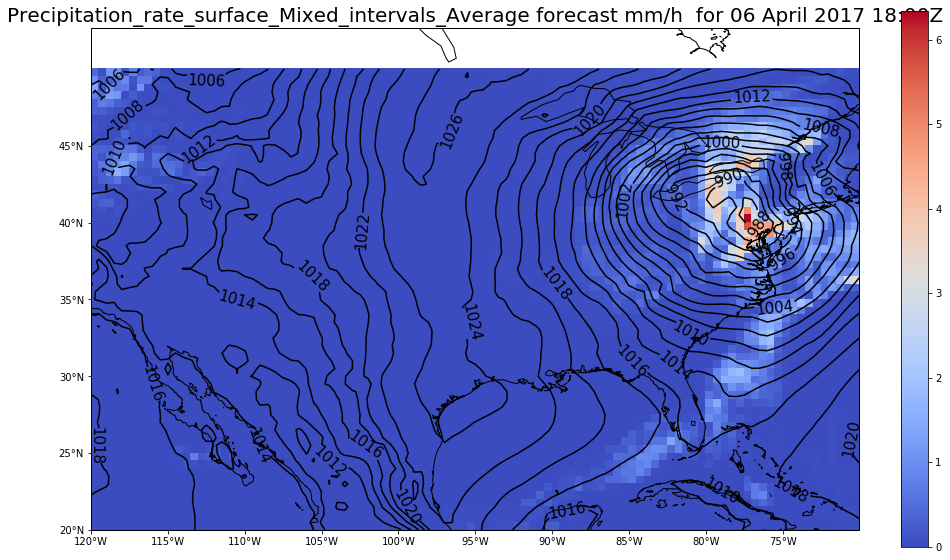

In [91]:
my_ax = plot_pcolor_mslp(ncss, bbox, var='Precipitation_rate_surface_Mixed_intervals_Average', tk=5, 
                        forecast_hour=3, mult=60.*60., unit='mm/h')
my_ax.add_feature(cfeature.LAKES, edgecolor='k', facecolor='none')


In [75]:
my_ax.add_feature?

In [92]:
for fc in np.arange(0,36,3):
    print(fc)
    

0
3
6
9
12
15
18
21
24
27
30
33
